## import libs

In [27]:
import pandas as pd
import numpy as np
from fuzzywuzzy import process
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import VotingRegressor

from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from lightgbm import LGBMClassifier

import joblib

In [ ]:
#### Forecast - оставить только ингридиенты
#### Nutrition facts - для оставленных ингридиентов собрать КБЖУ+витамины

## read files

In [2]:
df = pd.read_csv(r"data/epi_r.csv")

In [3]:
with open(r"data/ingredients.txt", 'r', encoding='utf-8') as file:
    # Читаем все строки в файл
    lines = file.readlines()
    ingredients = [line.strip() for line in lines]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20052 entries, 0 to 20051
Columns: 680 entries, title to turkey
dtypes: float64(679), object(1)
memory usage: 104.0+ MB


In [4]:
df.head()

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
0,"Lentil, Apple, and Turkey Wrap",2.500,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Potato and Fennel Soup Hodge,3.750,165.0,6.0,7.0,165.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Mahi-Mahi in Tomato Olive Sauce,5.000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Spinach Noodle Casserole,3.125,547.0,20.0,32.0,452.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# список ингридиентов взят с гитхаба: https://github.com/schollz/food-identicon/blob/master/ingredients.txt + добавлено 10 значений

### search for ingredients in columns

In [4]:
all_cols = df.columns.to_list()

In [5]:
def find_cols_in_ingr(all_cols, ingredients): # ищем столбцы в ингридиентах
    matches = set()
    ingredients = ', '.join(ingredients)
    for i in all_cols:
        if re.search(rf'\b{re.escape(i)}\b', ingredients, re.IGNORECASE):
            matches.add(i)
    return matches

In [6]:
def find_ingr_in_cols(all_cols, ingredients): # ищем ингридиенты в столбцах
    matches = set()
    for i in ingredients:
        # Создаем регулярное выражение для поиска слова i в любом элементе ingredients
        pattern = re.compile(rf'\b{re.escape(i)}\b', re.IGNORECASE)
        for ingredient in all_cols:
            if pattern.search(ingredient):
                matches.add(ingredient)  # Добавляем строку в список
    return matches

In [7]:
result_re_cols_in_ingr = find_cols_in_ingr(all_cols, ingredients) 
result_re_ingr_in_cols = find_ingr_in_cols(all_cols, ingredients) 

In [8]:
del_from_col = set(["summer", "no sugar added", "tree nut free", "sugar conscious", 
                   "winter", "dinner", "dessert", "soy free", "wheat/gluten-free", 
                   "boil", "spring", "breakfast", "low sodium", "california", 'self', 'low/no sugar', 
                   'kosher for passover'])

In [9]:
print(len(result_re_cols_in_ingr))
print(len(result_re_ingr_in_cols))
print(len(result_re_cols_in_ingr.union(result_re_ingr_in_cols)))

355
355
409


In [10]:
ingr_cols = result_re_cols_in_ingr.union(result_re_ingr_in_cols) - del_from_col
rest_cols = set(all_cols)-set(ingr_cols)

In [11]:
len(rest_cols)

288

In [12]:
# основной объем оставшихся значений - это название штатов, праздников, а также типов приема пищи
print(list(rest_cols)[250:])

['friendsgiving', 'spritzer', 'lunar new year', 'gourmet', 'kansas city', 'germany', 'blender', 'stir-fry', 'ohio', 'christmas', 'suzanne goin', 'family reunion', 'hawaii', 'kidney friendly', 'cuba', 'grill/barbecue', '22-minute meals', 'chill', 'california', 'purim', 'mortar and pestle', 'quince', 'dorie greenspan', 'costa mesa', 'virginia', 'engagement party', 'atlanta', 'missouri', 'house cocktail', 'epi + ushg', 'thanksgiving', 'ramadan', 'slow cooker', 'kentucky', 'healdsburg', 'tennessee', 'italy', 'picnic']


In [ ]:
# сохранение отобранных столбцов с ингредиентами
pd.Series(list(ingr_cols - {'protein', 'fat', 'sodium'})).to_csv(r'data/created/selected_columns_ingredients.csv', index = False)

## Data preporation to modeling

In [ ]:
# есть КБЖУ - для оценки качества блюда они могут быть важны, однако при передаче данных их не будет - можно проверить, важны ли
# и если да - то проводить дополнительный расчет на df Nutrition Facts
# остальные переменные дамми, но эти - нет, если использовать, то скалировать

In [7]:
ingr_cols = pd.read_csv(r'data/created/selected_columns_ingredients.csv', header=None).iloc[:,0].to_list()[1:]

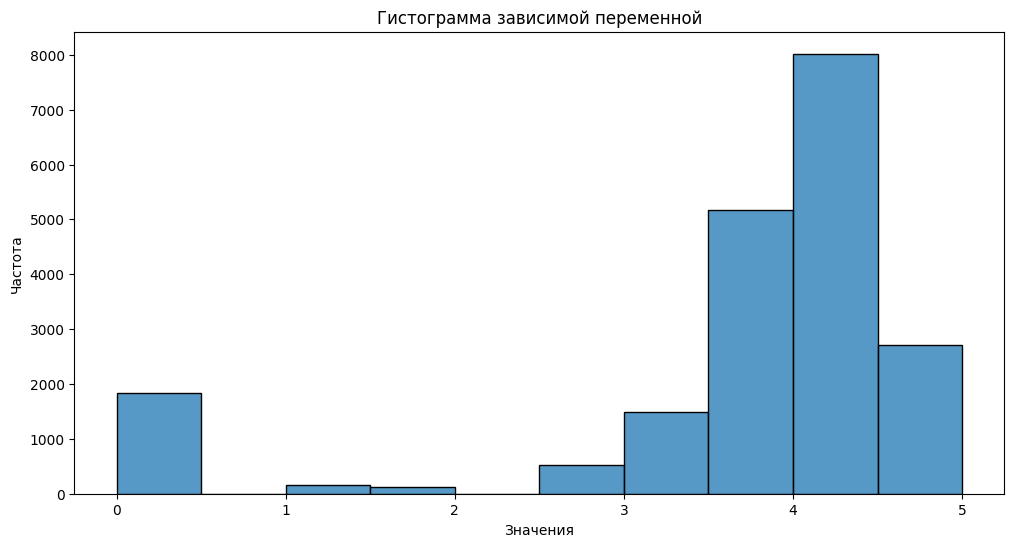

In [14]:
plt.figure(figsize=(12, 6))
sns.histplot(df['rating'], bins=10, kde=False)  # kde=True добавляет график плотности
plt.title('Гистограмма зависимой переменной')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.show()

In [9]:
X = df[list(ingr_cols)]
y = df['rating']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

## Feature selection. Regression

In [15]:
random_state = 21

1. Ueful func

In [16]:
def count_elected_cols(model, X_train, y_train, cutoff = 0.002):
    importances = model.fit(X_train, y_train).feature_importances_
    return len(importances[importances>cutoff])

In [17]:
def fs_rfe(estimator, X_train, y_train, feauture_number):
    rfe = RFE(estimator=estimator, n_features_to_select=feauture_number)
    rfe.fit(X_train, y_train)
    selected_features = rfe.support_
    df_rfe_imp = pd.DataFrame(selected_features*1, index = X_train.columns, columns=["feature"])
    return df_rfe_imp

2. Selection

In [ ]:
# Остальные можно либо объединить в другое, либо нет
# в любом случае для всех ингридиентов будет рассчитываться протеин, жир и содиум - они и будет использоваться для погнозирования

In [ ]:
# Для RFR: 2 m 5.1 s на всех признаках (более 400), 34.4 с на 125

In [31]:
dtr = DecisionTreeRegressor(random_state=random_state)
dtr.fit(X_train, y_train)
dtr_importances = dtr.feature_importances_

In [37]:
df_dtr_imp = pd.DataFrame(dtr_importances, index = X_train.columns, columns=["feature"])

<Axes: >

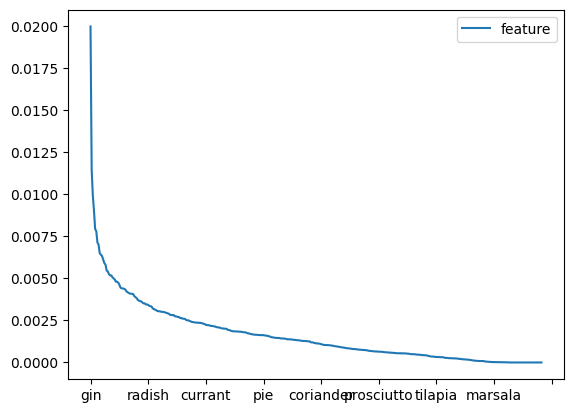

In [44]:
df_dtr_imp.sort_values(by="feature", ascending=False).iloc[3:].plot()

In [ ]:
numb_fs = round((count_elected_cols(RandomForestRegressor(random_state=random_state), X_train, y_train)+
           count_elected_cols(DecisionTreeRegressor(random_state=random_state), X_train, y_train))/2)

In [55]:
df_rfe_dtr_imp = fs_rfe(DecisionTreeRegressor(random_state=random_state), X_train,
                        y_train, numb_fs)

In [57]:
df_rfe_rfr_imp = fs_rfe(RandomForestRegressor(random_state=random_state), X_train,
                        y_train, numb_fs)

In [82]:
fs_cols = list(set(df_rfe_rfr_imp[df_rfe_rfr_imp['feature']==1].index).union(df_rfe_dtr_imp[df_rfe_dtr_imp['feature']==1].index) - {'self', 'low/no sugar'})

In [ ]:
# сохранение выбранных RFE переменных
pd.Series(fs_cols).to_csv(r'data/created/selected_feature_rfe_dtr_vs_rfr.csv', index = False)

In [33]:
lgbr = LGBMRegressor(random_state=random_state)
lgbr.fit(X_train.values, y_train.values)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1351
[LightGBM] [Info] Number of data points in the train set: 16041, number of used features: 296
[LightGBM] [Info] Start training from score 3.712869


LGBMRegressor(random_state=21)

In [34]:
df_lgbr_imp = pd.DataFrame(lgbr.feature_importances_/np.sum(lgbr.feature_importances_), index = X_train.columns, columns=["feature"])

<Axes: >

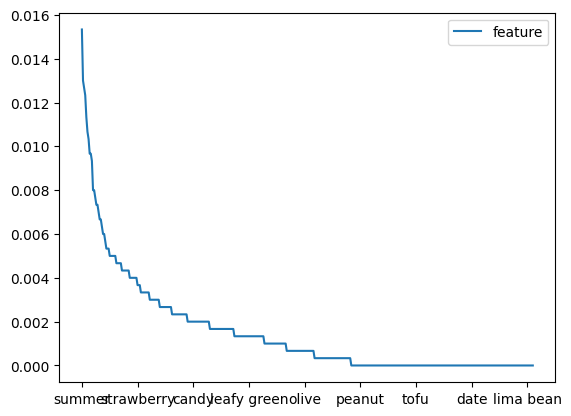

In [ ]:
df_lgbr_imp.sort_values(by="feature", ascending=False).iloc[3:].plot()

In [40]:
fs_cols_vs_lgbr = list(set(fs_cols).union(set(df_lgbr_imp[df_lgbr_imp['feature']>0.002].sort_values(by="feature", ascending=False).index)))

In [ ]:
# сохранение выбранных RFE переменных + lgbr
pd.Series(fs_cols_vs_lgbr).to_csv(r'data/created/selected_feature_rfe_dtr_vs_rfr_and_lgbr.csv', index = False)

## Regression

In [22]:
fs_cols_vs_lgbr = pd.read_csv(r'data/created/selected_feature_rfe_dtr_vs_rfr_and_lgbr.csv', header=None).iloc[:,0].to_list()[1:]

In [23]:
X_train_fs = X_train[fs_cols_vs_lgbr]
X_test_fs = X_test[fs_cols_vs_lgbr]

1. useful func

In [24]:
def RMSE(y_test, y_pred):
    return np.sqrt(mean_squared_error(y_test, y_pred))

In [ ]:
# оценщик для GridSearch
rmse_scorer = make_scorer(RMSE, greater_is_better=False)

In [28]:
def gridSearch(X_train, y_train, model, param_grid, scorer = "neg_root_mean_squared_error", random_search = True, n_iter = 100, random_state = random_state, sample_size=1, kfold_type = 'reg'):
    if sample_size < 1.0:
        X_train = X_train.sample(frac=sample_size, random_state=random_state)
        y_train = y_train.loc[X_train.index]  # Убедитесь, что y_train соответствует X_train
    if kfold_type == "reg":
        skf = KFold(n_splits=5, shuffle=True, random_state=random_state)
    else:
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    if random_search:
        print("RandomizedSearchCV")
        grid_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, 
                                           n_iter=n_iter, scoring=scorer, 
                                           cv=skf, return_train_score=True, n_jobs=-1, random_state=random_state,
                                           verbose=True)
    else:
        print("GridSearchCV")
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorer, cv=skf, return_train_score=True,
                               n_jobs=-1, verbose=True)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    results_df = pd.DataFrame(grid_search.cv_results_)

    results_df_sorted = results_df.sort_values(by='rank_test_score')
    return best_params, best_score, results_df_sorted

#### Naive forecast

In [29]:
average_rating = np.mean(y_train)
y_pred = np.full_like(y_test, average_rating)
print(f"naive RMSE: {RMSE(y_test, y_pred)}")

naive RMSE: 1.307237065771332


#### Decision Tree

In [30]:
dtr = DecisionTreeRegressor()

1. Начальный поиск оптимальных параметров

In [31]:
param_grid_dtr = {
    'max_depth': [3, 5, 7, 10, 15, 20, 25, 30, None],  # None означает, что глубина не ограничена
    'max_features': ['sqrt', 'log2', 0.3, 0.5, 0.7, None],  # None означает, что используются все признаки
    'min_samples_split': range(2, 20),  # Минимум 2 образца для разделения
    'min_samples_leaf': range(1, 6),
    'random_state': [random_state]
}

In [32]:
best_params_dtr, best_score_dtr, results_df_sorted_dtr = gridSearch(X_train_fs, y_train, dtr, param_grid_dtr, n_iter=500, sample_size=0.2)
print(best_params_dtr, best_score_dtr)

RandomizedSearchCV
Fitting 5 folds for each of 500 candidates, totalling 2500 fits


{'random_state': 21, 'min_samples_split': 19, 'min_samples_leaf': 5, 'max_features': 0.7, 'max_depth': 10} -1.2783818420523514


2. Вторичный поиск оптимальных параметров

In [33]:
param_grid_dtr2 = {
    'max_depth': [7, 10, 20],  
    'max_features': ['sqrt', 'log2', 0.5],  
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 6],
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error'],
    'splitter': ['best', 'random'],
    'min_weight_fraction_leaf': [0.0, 0.1, 0.2],
    'max_leaf_nodes': [10, 20, 50],
    'random_state': [random_state]
}

In [34]:
best_params_dtr2, best_score_dtr2, results_df_sorted_dtr2 = gridSearch(X_train_fs, y_train, dtr, param_grid_dtr2, n_iter=500, sample_size=0.2)
print(best_params_dtr2, best_score_dtr2)

RandomizedSearchCV
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
{'splitter': 'best', 'random_state': 21, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 20, 'min_samples_leaf': 4, 'max_leaf_nodes': 10, 'max_features': 0.5, 'max_depth': 10, 'criterion': 'friedman_mse'} -1.2754024846323837


3. Итоговая модель

In [35]:
best_params_dtr = best_params_dtr if best_score_dtr < best_score_dtr2 else best_params_dtr2
dtr_fin = DecisionTreeRegressor(**best_params_dtr)

#### RandomForestRegressor

In [36]:
rfr = RandomForestRegressor()

1. Начальный поиск оптимальных параметров

In [40]:
param_grid_rfr_random = {
    'n_estimators': [50, 100, 150, 200, 250, 300],
    'max_depth': [3,5,7,10,15,20,25,30],
    'max_features': ['sqrt', 'log2', 0.3, 0.5, 0.7],
    "min_samples_split" : randint(2, 20),
    'min_samples_leaf' : randint(1, 6),
    'random_state': [random_state]
}

In [41]:
best_params_rfr, best_score_rfr, results_df_sorted_rfr = gridSearch(X_train_fs, y_train, rfr, param_grid_rfr_random, n_iter=20, sample_size=0.2)
print(best_params_rfr, best_score_rfr)

RandomizedSearchCV
Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'max_depth': 10, 'max_features': 0.3, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 150, 'random_state': 21} -1.2568299680081743


2. Вторичный поиск оптимальных параметров

In [42]:
param_grid_rfr_random2 = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [5, 7,10,15,20],
    'max_features': ['sqrt', 'log2', 0.3, 0.5],
    #'bootstrap': [True, False],
    "min_samples_split" : [2, 5, 10, 20],
    'min_samples_leaf' : [1, 2, 4, 6],
    #'criterion' : ['squared_error', 'absolute_error'],
    'random_state': [random_state]
}

In [43]:
best_params_rfr2, best_score_rfr2, results_df_sorted_rfr2 = gridSearch(X_train_fs, y_train, rfr, param_grid_rfr_random2, n_iter=50, sample_size=0.2)
print(best_params_rfr2, best_score_rfr2)

RandomizedSearchCV
Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'random_state': 21, 'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 15} -1.2523294461941474


3. Итоговая модель

In [44]:
best_params_rfr = best_params_rfr if best_score_rfr < best_score_rfr2 else best_params_rfr2
rfr_fin = RandomForestRegressor(**best_params_rfr)

#### LGBMRegressor

In [45]:
lgbr = LGBMRegressor()

1. Начальный поиск оптимальных параметров

In [46]:
param_grid_lgbr = {
    'num_leaves': [31, 63],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100],
    'min_child_samples': [20, 50, 100, 200],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0, 0.1, 0.5, 1.0],
    'min_split_gain': [0, 0.1, 0.2],
    'random_state': [random_state],
    'verbose': [-1]
}

In [49]:
best_params_lgbr, best_score_lgbr, results_df_sorted_lgbr = gridSearch(X_train_fs, y_train, lgbr, param_grid_lgbr, n_iter=20, sample_size=0.2)

RandomizedSearchCV
Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [50]:
print(best_params_lgbr, best_score_lgbr)

{'verbose': -1, 'reg_lambda': 0.1, 'reg_alpha': 1.0, 'random_state': 21, 'num_leaves': 63, 'n_estimators': 100, 'min_split_gain': 0.1, 'min_child_samples': 20, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.8} -1.2683783061577103


2. Итоговая модель

In [52]:
lgbr_fin = LGBMRegressor(**best_params_lgbr)

#### Ensembles

1. Voting regressor

In [53]:
estimators=[
    ('lgbm', lgbr_fin),
    ('dtr', dtr_fin),
    ('rfr', rfr_fin)]
weights = [
    [1, 1, 1],  # Все модели имеют одинаковый вес
    [2, 1, 1],  # Первая модель имеет больший вес
    [1, 2, 1],  # Вторая модель имеет больший вес
    [1, 1, 2],   # Третья модель имеет больший вес
    [4, 1, 1],
    [1, 4, 1],
    [1, 1, 4],
    [4, 1, 4]
]

In [54]:
voting_regr = VotingRegressor(estimators=estimators)

In [57]:
param_grid_voting = {
    'weights': weights
}

In [58]:
# Полный набор
best_params_voting, best_score_voting, results_df_sorted_voting = gridSearch(X_train_fs, y_train, voting_regr, param_grid_voting, random_search=False, sample_size=0.2)

GridSearchCV
Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [59]:
print(best_params_voting, best_score_voting)

{'weights': [1, 1, 4]} -1.2556323403576322


##### Best models comparation

In [60]:
def model_test_estimation(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    print(f"RMSE for {model.__class__.__name__} : {RMSE(y_test, model.predict(X_test))}")

In [61]:
estimators=[
    ('lgbm', lgbr_fin),
    ('dtr', dtr_fin),
    ('rfr', rfr_fin)]
voting_fin = VotingRegressor(estimators=estimators, weights = [4, 1, 4])
models = [dtr_fin, rfr_fin, lgbr_fin, voting_fin]
for model in models:
    model_test_estimation(model, X_train_fs, X_test_fs, y_train, y_test)

RMSE for DecisionTreeRegressor : 1.286551958109988
RMSE for RandomForestRegressor : 1.2633345993796923
RMSE for LGBMRegressor : 1.2576653516724123
RMSE for VotingRegressor : 1.2594395462960233


## Classification

In [62]:
y_cls = y.round().astype(int)

In [63]:
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X, y_cls, test_size=0.2, random_state=random_state, stratify=y_cls)

In [64]:
X_train_cls_fs = X_train_cls[fs_cols_vs_lgbr]
X_test_cls_fs = X_test_cls[fs_cols_vs_lgbr]

#### Naive forecast

In [65]:
naive_classifier = DummyClassifier(strategy="most_frequent")
naive_classifier.fit(X_train_cls_fs, y_train_cls)

# Делаем предсказания на тестовых данных
y_pred = naive_classifier.predict(X_test_cls_fs)

# Оцениваем качество классификатора
print("Accuracy:", accuracy_score(y_test_cls, y_pred))

Accuracy: 0.6576913487908252


#### SVC

In [66]:
param_grid_svc = {
    'C': [0.01, 0.1, 1, 10, 100],  # Параметр регуляризации
    'kernel': ['rbf'],  # Тип ядра
    'class_weight': ['balanced'],  # Веса классов
    "random_state" : [21],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]
}

In [67]:
SVC_cls = SVC(class_weight='balanced', random_state=random_state)

In [68]:
SVC_cls.fit(X_train_cls_fs, y_train_cls)
print(accuracy_score(y_train_cls, SVC_cls.predict(X_train_cls_fs)))

0.5926064459821707


In [69]:
best_params_svc, best_score_svc, results_df_sorted_svc = gridSearch(X_train_cls_fs, y_train_cls, SVC_cls, param_grid_svc, scorer="accuracy", random_search = False, sample_size = 0.2)
print(best_params_svc, best_score_svc)

GridSearchCV
Fitting 5 folds for each of 30 candidates, totalling 150 fits


{'C': 100, 'class_weight': 'balanced', 'gamma': 1, 'kernel': 'rbf', 'random_state': 21} 0.6190769873785605


#### RandomForestClassifier

In [73]:
rfc_model = RandomForestClassifier(n_estimators=100, max_depth=25,random_state=random_state)
rfc_model.fit(X_train_cls_fs, y_train_cls)
print(accuracy_score(y_train_cls, rfc_model.predict(X_train_cls_fs)))

0.7108035658624774


In [76]:
param_grid_rfc = {
    'n_estimators': [50, 100, 200],  # Количество деревьев
    'max_depth': [None, 10, 20, 30],  # Максимальная глубина
    'min_samples_split': [2, 5, 10],  # Минимальное количество образцов для разделения
    'min_samples_leaf': [1, 2, 4],  # Минимальное количество образцов в листе
    'max_features': ['sqrt', 'log2', 0.5],  # Количество признаков для разделения
    'bootstrap': [True, False],  # Использование бутстрэпа
    'class_weight': [None, 'balanced'],  # Веса классов
    'criterion': ['gini', 'entropy'],  # Критерий разделения
    'max_leaf_nodes': [None, 10, 20, 50],  # Максимальное количество листовых узлов
    "random_state" : [21]
}

In [77]:
rfc_model = RandomForestClassifier()

In [79]:
best_params_rfc, best_score_rfc, results_df_sorted_rfc = gridSearch(X_train_cls_fs, y_train_cls, rfc_model, param_grid_rfc, scorer="accuracy", random_search = True, n_iter=300, sample_size = 0.2, kfold_type="cls")
print(best_params_rfc, best_score_rfc)

RandomizedSearchCV
Fitting 5 folds for each of 300 candidates, totalling 1500 fits


{'random_state': 21, 'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_leaf_nodes': None, 'max_features': 'sqrt', 'max_depth': 30, 'criterion': 'gini', 'class_weight': None, 'bootstrap': True} 0.6574214744290706


##### Best models comparation

In [80]:
def model_test_estimation_cls(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    print({model.__class__.__name__}, ":")
    print(f"Accuracy : {accuracy_score(y_test, model.predict(X_test))}")
    print(f"Presicion : {precision_score(y_test, model.predict(X_test), average='macro')}")

In [81]:
fin_rfc = RandomForestClassifier(**best_params_rfc)
fin_svc = SVC(**best_params_svc)
models_svc = [fin_rfc, fin_svc]
for model in models_svc:
    model_test_estimation_cls(model, X_train_cls_fs, X_test_cls_fs,
                              y_train_cls, y_test_cls)

{'RandomForestClassifier'} :
Accuracy : 0.6733981550735477


/home/alagis/S21/DS_Bootcamp/jannmart/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Presicion : 0.2943789741676541
{'SVC'} :
Accuracy : 0.62528047868362
Presicion : 0.34181421797977


## Classification. 3

In [82]:
bins = [-1, 1, 3, 5]  # Границы интервалов
labels = [0, 1, 2]  # Метки классов

# Преобразуем целевую переменную
y_cls_3 = pd.cut(y_cls, bins=bins, labels=labels)

In [83]:
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X, y_cls_3, test_size=0.2, random_state=random_state, stratify=y_cls_3)

In [84]:
X_train_cls_fs = X_train_cls[fs_cols_vs_lgbr]
X_test_cls_fs = X_test_cls[fs_cols_vs_lgbr]

#### Naive forecast

In [94]:
naive_classifier = DummyClassifier(strategy="most_frequent")
naive_classifier.fit(X_train_cls_fs, y_train_cls)

# Делаем предсказания на тестовых данных
y_pred = naive_classifier.predict(X_test_cls_fs)

# Оцениваем качество классификатора
print("Accuracy:", accuracy_score(y_test_cls, y_pred))
print("Precision:", precision_score(y_test_cls, y_pred, average='macro'))

Accuracy: 0.7933183744702069
Precision: 0.26443945815673564


/home/alagis/S21/DS_Bootcamp/jannmart/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### SVC

In [90]:
SVC_cls = SVC(class_weight='balanced', random_state=random_state)
SVC_cls.fit(X_train_cls_fs, y_train_cls)
print(accuracy_score(y_train_cls, SVC_cls.predict(X_train_cls_fs)))
print(precision_score(y_train_cls, SVC_cls.predict(X_train_cls_fs), average='macro'))

0.7129854747210274
0.590114261151454


In [87]:
best_params_svc, best_score_svc, results_df_sorted_svc = gridSearch(X_train_cls_fs, y_train_cls, SVC_cls, param_grid_svc, scorer="accuracy", n_iter=30, sample_size = 0.2, kfold_type='cls')
print(best_params_svc, best_score_svc)

RandomizedSearchCV
Fitting 5 folds for each of 30 candidates, totalling 150 fits


{'random_state': 21, 'kernel': 'rbf', 'gamma': 1, 'class_weight': 'balanced', 'C': 100} 0.7702640442066281


In [88]:
best_params_svc_pm, best_score_svc_pm, results_df_sorted_svc_pm = gridSearch(X_train_cls_fs, y_train_cls, SVC_cls, param_grid_svc, scorer="precision_macro", random_search = False, sample_size = 0.2, kfold_type='cls')

GridSearchCV
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/alagis/S21/DS_Bootcamp/jannmart/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alagis/S21/DS_Bootcamp/jannmart/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alagis/S21/DS_Bootcamp/jannmart/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

In [89]:
print(best_params_svc_pm, best_score_svc_pm)

{'C': 100, 'class_weight': 'balanced', 'gamma': 1, 'kernel': 'rbf', 'random_state': 21} 0.46651094216061306


#### RandomForestClassifier

In [95]:
rfc_model = RandomForestClassifier(n_estimators=100, max_depth=25,random_state=random_state)
rfc_model.fit(X_train_cls_fs, y_train_cls)
print(accuracy_score(y_train_cls, rfc_model.predict(X_train_cls_fs)))

0.8244498472663799


In [96]:
best_params_rfc, best_score_rfc, results_df_sorted_rfc = gridSearch(X_train_cls_fs, y_train_cls, rfc_model, param_grid_rfc, scorer="accuracy", random_search = True, n_iter=300, sample_size = 0.2, kfold_type='csf')

RandomizedSearchCV
Fitting 5 folds for each of 300 candidates, totalling 1500 fits


In [97]:
print(best_params_rfc, best_score_rfc)

{'random_state': 21, 'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_leaf_nodes': 20, 'max_features': 0.5, 'max_depth': None, 'criterion': 'entropy', 'class_weight': None, 'bootstrap': False} 0.7992496148444068


In [98]:
param_grid_rfc_3 = {
    'n_estimators': [100, 200, 300, 400],  # Увеличили диапазон
    'max_depth': [20, 25, 30, 35],  # Добавили промежуточные значения
    'min_samples_split': [2, 3, 4],  # Уменьшили значения
    'min_samples_leaf': [1, 2],  # Уменьшили значения
    'max_features': ['sqrt', 'log2', 0.3, 0.5, 0.7],  # Расширили диапазон
    'bootstrap': [True],  # Оставили без изменений
    'class_weight': [None, 'balanced'],  # Добавили 'balanced'
    'criterion': ['gini', 'entropy'],  # Оставили оба варианта
    'max_leaf_nodes': [None, 20, 30, 40, 50],  # Расширили диапазон
    'random_state': [21]  # Оставили фиксированным
}

In [99]:
best_params_rfc, best_score_rfc, results_df_sorted_rfc = gridSearch(X_train_cls_fs, y_train_cls, rfc_model, param_grid_rfc_3, scorer="accuracy", random_search = True, n_iter=300, sample_size = 0.2, kfold_type='csf')

RandomizedSearchCV
Fitting 5 folds for each of 300 candidates, totalling 1500 fits


In [100]:
print(best_params_rfc, best_score_rfc)

{'random_state': 21, 'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_leaf_nodes': 30, 'max_features': 0.3, 'max_depth': 20, 'criterion': 'gini', 'class_weight': None, 'bootstrap': True} 0.7992496148444068


In [101]:
best_params_rfc_pm, best_score_rfc_pm, results_df_sorted_rfc_pm = gridSearch(X_train_cls_fs, y_train_cls, rfc_model, param_grid_rfc_3, scorer="precision_macro", random_search = True, n_iter=300, sample_size = 0.2, kfold_type='csf')

RandomizedSearchCV
Fitting 5 folds for each of 300 candidates, totalling 1500 fits


/home/alagis/S21/DS_Bootcamp/jannmart/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alagis/S21/DS_Bootcamp/jannmart/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alagis/S21/DS_Bootcamp/jannmart/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

In [ ]:
print(best_params_rfc_pm, best_score_rfc_pm)

{'random_state': 21, 'n_estimators': 300, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_leaf_nodes': None, 'max_features': 'sqrt', 'max_depth': 35, 'criterion': 'entropy', 'class_weight': 'balanced', 'bootstrap': True} 0.5880575607718517


##### Best models comparation

In [102]:
fin_rfc_3 = RandomForestClassifier(**best_params_rfc_pm)
fin_svc_3 = SVC(**best_params_svc_pm)
models_svc_3 = [fin_rfc_3, fin_svc_3]
for model in models_svc_3:
    model_test_estimation_cls(model, X_train_cls_fs, X_test_cls_fs,
                              y_train_cls, y_test_cls)

{'RandomForestClassifier'} :
Accuracy : 0.8020443779606083
Presicion : 0.6616549322431675
{'SVC'} :
Accuracy : 0.7469458987783595
Presicion : 0.48328381079602895


In [103]:
fin_rfc_3 = RandomForestClassifier(**best_params_rfc_pm)
fin_svc_3 = SVC(**best_params_svc_pm)
models_svc_3 = [fin_rfc_3, fin_svc_3]
for model in models_svc_3:
    model_test_estimation_cls(model, X_train_cls, X_test_cls,
                              y_train_cls, y_test_cls)

{'RandomForestClassifier'} :
Accuracy : 0.8025430067314884
Presicion : 0.6447710592004768
{'SVC'} :
Accuracy : 0.8010471204188482
Presicion : 0.6266056391302233


## Save model

In [104]:
choosed_model = RandomForestClassifier(**best_params_rfc_pm).fit(X, 
                                                                 y_cls_3)

In [105]:
joblib.dump(choosed_model, r'model/choosed_model.pkl')

['model/choosed_model.pkl']

### Факты о пищевой ценности

* Соберите все факты о питании для ингредиентов из вашего подготовленного и отфильтрованного набора данных (только столбцы ингредиентов) в фреймворк данных. Используйте для этого следующий API .
* Преобразуйте все значения в % от дневной нормы. Оставьте только те ингредиенты, которые есть в этой и той таблице.
* Сохраните преобразованный фрейм данных в CSV-файл, который вы будете использовать в своей основной программе.

In [ ]:
def creation_nutrition_dict(data, food_component, ingridient):
        nutrients = food_component['Nutrient'].tolist()
        if data["foods"]:
                food_nutrients = data["foods"][0]["foodNutrients"]
                nutrition_dict = {}
                for item in food_nutrients:
                    nutrient_name = item['nutrientName'].split(",")[0]
                    nutrient_value = item['value']
                    
                    if nutrient_name in nutrients:
                        adult_value = int(food_component.loc[food_component["Nutrient"] == nutrient_name, "Adults"].item())
                        if adult_value != 0 and nutrient_value != 0:
                            nutrition_dict[nutrient_name] = {'value': round((nutrient_value * 100) / adult_value, 2)}
                return nutrition_dict
        else:
                print(f"No nutrition information found for {ingridient}")
                return {}

In [ ]:
import requests
import csv
import pandas as pd

filename = "data/output.csv"
food_component = pd.read_csv('data/created/Food Component.csv')
name_list = food_component['Nutrient'].tolist()
name_list.insert(0, 'ingridient')
df = pd.read_csv('data/selected_columns_ingredients.csv')
ingridients = df['Name'].tolist()

In [ ]:
with open(filename, 'w', newline='', encoding='utf-8') as csvfile:
    csvwriter = csv.writer(csvfile)
    header = name_list
    csvwriter.writerow(header)
    # ingridients = ['milk', 'honey']
    api_key = "IX5S46qsEClnweZbMl7lyUERsakslbcRT1dgoiTr"
    nutrients = []
    for ingridient in ingridients:
        url = f"https://api.nal.usda.gov/fdc/v1/foods/search?query={ingridient}&api_key={api_key}"
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        nutrients_dict = creation_nutrition_dict(data, food_component, ingridient)
        row = [ingridient]
        for nutrient in name_list[1:]:
            if nutrient in nutrients_dict:
                row.append(nutrients_dict[nutrient]['value'])
            else:
                row.append(0)

        csvwriter.writerow(row)
        print(ingridient)

pot pie
persimmon
meatloaf
grape
shallot
vanilla
sauce
beef shank
marinade
ground beef
idaho
lamb
bass
scallop
buffalo
rack of lamb
anchovy
bean
salmon
blueberry
lentil
cake
watermelon
bok choy
vinegar
halibut
quinoa
sugar snap pea
fish
louisiana
tortillas
trout
jerusalem artichoke
prosciutto
sparkling wine
spinach
pineapple
swordfish
eggplant
poultry
sweet potato
yam
vodka
tequila
corn
dried fruit
lemon juice
No nutrition information found for rosé
rosé
saffron
calvados
brandy
tropical fruit
cumin
tamarind
caraway
macadamia nut
radicchio
liqueur
triple sec
oregano
guava
raspberry
noodle
salad dressing
lemongrass
cinnamon
hummus
oat
artichoke
tapioca
coriander
orange juice
stew
kiwi
butterscotch
caramel
low sugar
turkey
cardamom
hamburger
hot pepper
flat bread
cabbage
chili
olive
feta
vegan
soy
fennel
mango
parsley
scotch
cheese
strawberry
bitters
chickpea
cranberry sauce
dill
lobster
pine nut
bell pepper
rutabaga
broccoli
fry
cilantro
fig
pork rib
mayonnaise
basil
buttermilk
veal
taco

### Похожие рецепты

* Для каждого рецепта из набора данных соберите URL-адрес с сайта epicurious.com с его подробностями (если URL-адрес для этого рецепта отсутствует, пропустите его).
* Сохраните новый фрейм данных в CSV-файл, который вы будете использовать в своей основной программе.

In [ ]:
import requests
from bs4 import BeautifulSoup
import csv
import pandas as pd

# Формируем URL для поиска
headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
        }
i = 0
filename = "data/link.csv"
data = pd.read_csv("data/epi_r.csv")

In [ ]:
with open(filename, 'w', newline='', encoding='utf-8') as csvfile:
    csvwriter = csv.writer(csvfile)
    header = ['recept', 'rating', 'url']
    csvwriter.writerow(header)
    for recept in data.title:
        # if i > 30: break
        query = recept.strip().replace('"', '')
        url = f"https://www.epicurious.com/search?q={query.replace(' ', '%20')}&page=1&content=recipe"
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')
            link = None
            for links in soup.find_all('a', class_="BaseWrap-sc-gjQpdd BaseText-ewhhUZ BaseLink-eNWuiM Link-ehXskl iUEiRd bjMGUM kxxKIa", href=True):
                    if links.text.strip() == query:
                        link = "https://www.epicurious.com" + links['href']
                        break
                    else:
                         link = f"Link to recipe '{recept}' not found"
            
        else:
            print(f"Ошибка: {response.status_code}")
        rating = data[data["title"] == recept]["rating"].values[0]
        results = [recept, rating, link]
        print(f'{i}: {recept}, url:{url}, link:{link}')
        i += 1
        csvwriter.writerow(results)

### Разделение столбцов использующих "/" в epi_r.csv

In [ ]:
import pandas as pd
import re

# Пример данных
data = {
    'title': ['The Best BLTs', 'Peach Mustard', 'Deviled Ham'],
    'milk/cream': [1, 0, 1],
    'jam or jelly': [0, 1, 1],
    'kiwi': [1, 1, 0],
    'cognac/armagnac': [0, 0, 0],
    'kitchen olympics' : [1, 1, 1]
}

# Создаем DataFrame
df = pd.read_csv('data/epi_r.csv')

# Создаем DataFrame
# df = pd.DataFrame(data)

new_columns = pd.DataFrame()

new_columns_dict = {}

for col in df.columns[1:]:
    parts = re.split(r'[/]', col)
    for part in parts:
        new_columns_dict[part] = df[col].apply(lambda x: 1 if x == 1 else 0)

new_columns = pd.DataFrame(new_columns_dict)

new_columns.drop(columns=new_columns.columns[:4], inplace=True)
df.drop(columns=df.columns[4:], inplace=True)
df = pd.concat([df, new_columns], axis=1)

# df.to_csv('data/extended_table.csv')

694


### Получение значений ингридиентов для необходимого рецепта

In [ ]:
import pandas as pd

df = pd.read_csv('data/extended_table.csv')
recipe = 'Eggs Benedict Salad '

print(df[df['title'] == recipe][['rating', 'fat', 'calories', 'sodium', 'protein']])
recipe_row = df[df['title'] == recipe]
# ingridients = recipe_row.drop('title', axis=1)
ingridients_in_recipe = ingridients.columns[ingridients.iloc[0] == 1].tolist()
print(ingridients_in_recipe)

       rating   fat  calories  sodium  protein
20017   4.375  45.0     530.0  1205.0     21.0
['bon appétit', 'buffet', 'chicken', 'cilantro', 'food processor', 'ginger', 'lunch', 'pasta', 'peanut', 'quick & easy', 'salad', 'soy sauce', 'tree nut free', 'vegetable', 'wisconsin']


### Разделение рецептов на завтрак, обед и ужин

In [ ]:
df = pd.read_csv('data/extended_table.csv')
breakfasts = df[df["breakfast"] == 1]["title"].values
breakfasts

array(['Spicy Noodle Soup ', 'Sweet Buttermilk Spoon Breads ',
       'Citrus Salad with Mint Sugar ', 'Peanut Butter-Banana Muffins ',
       'Pumpkin Muffins ', 'Ricotta Omelets ',
       'Apricot-Pistachio Muffins Baked on the Grill ',
       'Cranberry, Quince, and Pearl Onion Compote ', 'Banana Smoothie ',
       'Banana Coffee Cake Diamond ',
       'Raisin-Bread Strata with Sausage and Dried Plums ',
       'Breakfast Bowl With Quinoa and Berries ', 'Cornmeal Waffles ',
       'Dried-Cranberry Spread ',
       'Beet, Carrot, and Apple Juice with Ginger ',
       'Haricots Verts With Poached Eggs And Tarragon Vinaigrette ',
       'Zucchini Raisin Bran Muffins ',
       'Spanish Frittata with Prosciutto, Potatoes and Peas ',
       'Ashkenazic Sour Cream Coffee Cake (Smeteneh Küchen) ',
       "Grandmother Walters's Biscuits ", 'Oeufs Au Plat ',
       'Rice Pancakes ',
       'Peaches and Cream Shortcakes with Cornmeal-Orange Biscuits ',
       'Cider-Glazed Mini Apple Muffins '

In [ ]:
import pandas as pd

df = pd.read_csv('data/epi_r.csv')

sodium = df['sodium']

db = pd.read_csv('data/extended_table.csv')

db['sodium'] = sodium
db = db.fillna(0)
# db_new = db_new.drop('Unnamed: 0', axis=1)
db.to_csv('data/extended_table.csv', index=False)